In [1]:
import os
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import mlflow
from mlflow.tracking.client import MlflowClient

from utils import get_results_dict, get_metrics_history_df

In [2]:
mlflow_tracking_uri = "file:///home/akira/Desktop/p-poteka/poteka-pipeline-pytorch/mlruns"
mlflow_experiment_id = "10"
save_img_dir_path = f"./results/{mlflow_experiment_id}/r2_score/standard"

os.makedirs(save_img_dir_path, exist_ok=True)

In [3]:
mlflow.set_tracking_uri(mlflow_tracking_uri)

In [4]:
standard_eval_runs = MlflowClient().search_runs("10", filter_string="tags.mlflow.project.entryPoint = 'evaluate'")
print(f"standard evaluate runs count: {len(standard_eval_runs)}")

standard evaluate runs count: 14


In [5]:
standard_results_dict = get_results_dict(standard_eval_runs)

In [12]:
param_names_list, seq_param_names_list = [], []
r2_scores_list, seq_r2_scores_list = [], []
keys_list, seq_keys_list = [], []
for param_name, results_dict in standard_results_dict["r2_scores"].items():
    for key, val in results_dict.items():
        if "Sequential" in key:
            seq_param_names_list.append(param_name)
            seq_r2_scores_list.append(val)
            keys_list.append(key)
        else:
            param_names_list.append(param_name)
            r2_scores_list.append(val)
            seq_keys_list.append(key)

df = pd.DataFrame({"input_parameters": param_names_list, "r2_score": r2_scores_list, "key": keys_list})
seq_df = pd.DataFrame({"input_parameters": seq_param_names_list, "r2_score": seq_r2_scores_list, "key": seq_keys_list})
df.describe()

,r2_score
count,126.000000
mean,0.339659
std,0.071633
min,0.183000
25%,0.285750
50%,0.333000
75%,0.389750
max,0.482000


In [7]:
seq_df.describe()

,r2_score
count,126.000000
mean,0.944587
std,0.010753
min,0.908000
25%,0.940000
50%,0.945500
75%,0.950750
max,0.972000


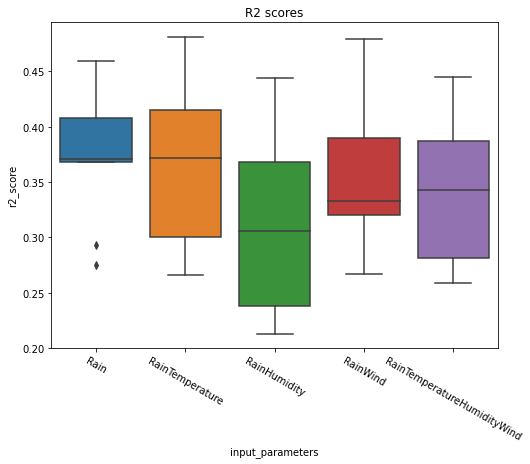

In [8]:
target_columns = ["Rain", "RainTemperature", "RainHumidity", "RainWind", "RainTemperatureHumidityWind"]
fig, ax = plt.subplots(figsize=(8, 6))
sns.boxplot(data=df.loc[df["input_parameters"].isin(target_columns)], x="input_parameters", y="r2_score", order=target_columns, ax=ax)
ax.set_title("R2 scores")
plt.xticks(rotation=330)
plt.savefig(f"{save_img_dir_path}/r2scores.png")

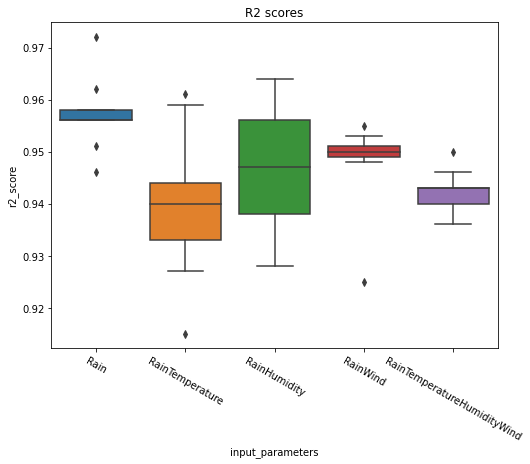

In [9]:
target_columns = ["Rain", "RainTemperature", "RainHumidity", "RainWind", "RainTemperatureHumidityWind"]
fig, ax = plt.subplots(figsize=(8, 6))
sns.boxplot(data=seq_df.loc[df["input_parameters"].isin(target_columns)], x="input_parameters", y="r2_score", order=target_columns)
ax.set_title("R2 scores")
plt.xticks(rotation=330)
fig.savefig(f"{save_img_dir_path}/seq_r2scores.png")

In [13]:
# Case rmses boxplot
df.head()

,input_parameters,r2_score,key
0,RainWind,0.479,r2_Sequential_prediction_2020-09-14_cases
1,RainWind,0.426,r2_Sequential_prediction_2019-10-12_cases
2,RainWind,0.373,r2_Sequential_prediction_TC_affected_cases
3,RainWind,0.328,r2_Sequential_prediction_2020-10-12_cases
4,RainWind,0.267,r2_Sequential_prediction_2020-08-07_cases


In [24]:
import re
# Get each cases r2 score
standard_eval_runs[0]
artifact_path = "file:///home/akira/Desktop/p-poteka/poteka-pipeline-pytorch/mlruns/10/39c0a640796c4cbda896915e86b34762/artifacts".replace("file://", "")
for dir_name in os.listdir(artifact_path + "/evaluations"):
    if re.match(".*_start$", dir_name) is not None:
        predict_result_dir_path = os.path.join(artifact_path, "evaluations", dir_name)

In [26]:
result_csv_name_regex = "^pred_observ_df_.*.csv$"
for filename in os.listdir(predict_result_dir_path):
    if re.match(result_csv_name_regex, filename) is not None:
        print(filename)

pred_observ_df_7-10.csv
pred_observ_df_7-30.csv
pred_observ_df_7-50.csv
pred_observ_df_7-0.csv
pred_observ_df_7-20.csv
pred_observ_df_7-40.csv


In [29]:
from sklearn.metrics import r2_score
pred_result_df = pd.read_csv(os.path.join(predict_result_dir_path, "pred_observ_df_7-0.csv"))
pred_result_df.head()
r2_score = r2 = r2_score(pred_result_df["hour-rain"].astype(float).values, pred_result_df["Pred_Value"].astype(float).values)
print(r2_score)

0.9540512988965106


In [14]:
# grouping by date
def get_grouped_case_date(case_name: str) -> str:
    # TC case
    if "2019-10-04" in case_name:
        return "2019-10-04"
    elif "2020-07-04" in case_name:
        return "2020-07-04"
    elif "2019-10-12" in case_name:
        return "2019-10-12"

    # Not TC case
    elif "2020-09-14" in case_name:
        return "2020-09-14"
    elif "2020-08-07" in case_name:
        return "2020-08-07"
    elif "2020-10-12" in case_name:
        return "2020-10-12"
    else:
        return "else"

df["date"] = df["key"].apply(get_grouped_case_date)
len(df.loc[df["date"] == "2019-10-04"])

14